In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from regimedetection.examples.brownianpaths.utils import simulate_wiener_process
from regimedetection.examples.brownianpaths.utils import simulate_gbm_process
from regimedetection.src.utils.plot import make_colours

In [6]:
sns.set_style("dark")

### Setup

In [18]:
n_time_steps = 100
n_paths = 20

time_steps = np.linspace(0, 1, n_time_steps)
path_colours = make_colours(n_paths)

### Wiener Process

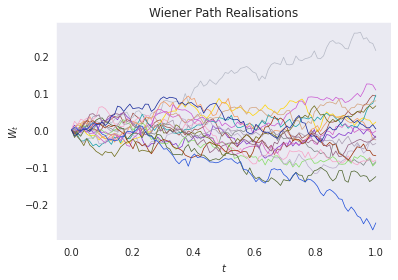

In [20]:
wiener_paths = simulate_wiener_process(time_steps, n_wiener_paths)

for path, colour in zip(wiener_paths, path_colours):
    plt.plot(time_steps, path, color=colour, lw=0.7)
    
plt.title("Wiener Path Realisations")
plt.xlabel("$t$")
plt.ylabel("$W_t$")
plt.show()

### Geometric Brownian Motion

$$
S(t) = S_0 \exp \left\{ \left( \mu - \frac{1}{2}\sigma^2 \right)t + \sigma W_t \right\}
$$

In [67]:
mu_sigma_values = ((0.15, 0.4), (0, 0.1))
initial_value = 1

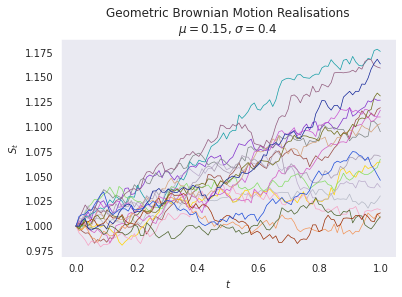

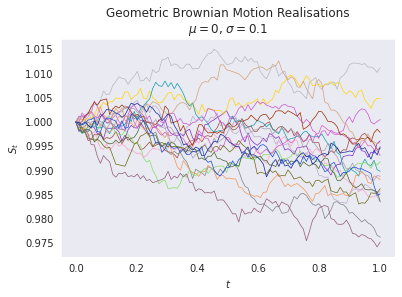

In [68]:
for mu, sigma in mu_sigma_values:
    gbm_paths = simulate_gbm_process(time_steps, n_paths, mu, sigma, initial_value)

    for path, colour in zip(gbm_paths, path_colours):
        plt.plot(time_steps, path, color=colour, lw=0.7)

    plt.title(f"Geometric Brownian Motion Realisations\n$\mu={mu}$, $\sigma={sigma}$")
    plt.xlabel("$t$")
    plt.ylabel("$S_t$")
    plt.show()